In [1]:
%cd /Users/gwg/dmcm
%matplotlib inline

/Users/gwg/dmcm


In [2]:
import numpy as np
import torch
import random
import matplotlib
import matplotlib.pyplot as plt
from   PIL import Image

from   data import GTExV8Config, loader
from   models import DPCCA

In [7]:
cfg = GTExV8Config()

directory = 'experiments/20190131_big_sweep/'\
            'gtexv8_mode-dpcca_batch_size-128_seed-0_latent_dim-10_lr-0.0001_l1_coef-0.5_em_iters-1_clip-1'

cfg.IMG_EMBED_DIM = cfg.GENE_EMBED_DIM = 100
state = torch.load(directory + '/model.pt', map_location={'cuda:0': 'cpu'})
model = DPCCA(cfg, latent_dim=10, use_gene_net=True)
model.load_state_dict(state)

In [8]:
train_loader, test_loader = loader.get_data_loaders(cfg,
                                                    batch_size=128,
                                                    num_workers=1,
                                                    pin_memory=False,
                                                    directory=directory)
dataset = train_loader.dataset

torch.Size([113, 3, 128, 128]) torch.Size([113, 39832])
torch.Size([308, 3, 128, 128]) torch.Size([308, 39832])
torch.Size([110, 3, 128, 128]) torch.Size([110, 39832])


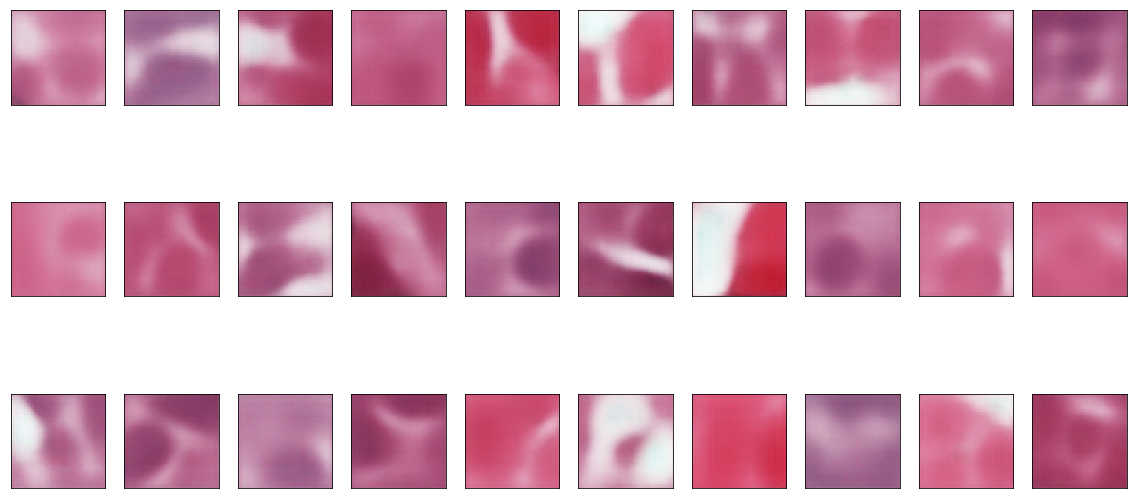

In [39]:
fig, axmat = plt.subplots(3, 10)
fig.set_size_inches(20, 10)

for tissue, axcol in zip(['Pancreas', 'Muscle - Skeletal', 'Brain - Cerebellum'], axmat):

    inds = train_loader.sampler.indices[:5000]
    n    = len(inds)

    X1 = torch.Tensor(n, cfg.N_CHANNELS, cfg.IMG_SIZE, cfg.IMG_SIZE)
    X2 = torch.Tensor(n, cfg.N_GENES)
    labels = []

    j = 1
    for idx in inds:
        lab = dataset.labels[idx]
        if lab != tissue:
            continue

        x1, x2 = dataset[idx]
        X1[j] = x1
        X2[j] = x2
        labels.append(lab)
        j += 1

    # Only get samples from a specific type:
    X1 = X1[:j]
    X2 = X2[:j]
    print(X1.shape, X2.shape)

    with torch.no_grad():
        X1r, X2r = model.sample([X1, X2], n_samples=10)
#         X1r = model.sample_x1_from_x2(X2)
        for x1r, ax in zip(X1r, axcol.flat):
            img = x1r.transpose(0, 2).numpy()

#             img = img - img.min()
#             img = img / img.max()

            ax.imshow(img)
            ax.set_xticks([])
            ax.set_yticks([])